In [1]:
import sys
import warnings
sys.path.append("..")

from data.data_loader import normalised_subspace, subspace, scaler
from synthetic_anomalies.generation import anomaly_dataset
import seaborn as sns

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

from benchmark import anom_types, models, model_outputs, init_algos
from evaluation import algo_results, algo_rank_results, result_df, plot_results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scienceplots
plt.style.use('science')

In [2]:
output = anomaly_dataset(
    anom_size=1000
)

In [3]:
tsne = TSNE()
X_embed = tsne.fit_transform(output.to_numpy()[:, 0:5])

output["tsne_x"] = X_embed[:, 0]
output["tsne_y"] = X_embed[:, 1]

/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_7702/3284612127.py:110: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [30]
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_7702/3284612127.py:111: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [30]
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_7702/3284612127.py:112: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[2]._sizes = [30]
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_7702/3284612127.py:113: MatplotlibDeprecationWarning: The legendHandles attri

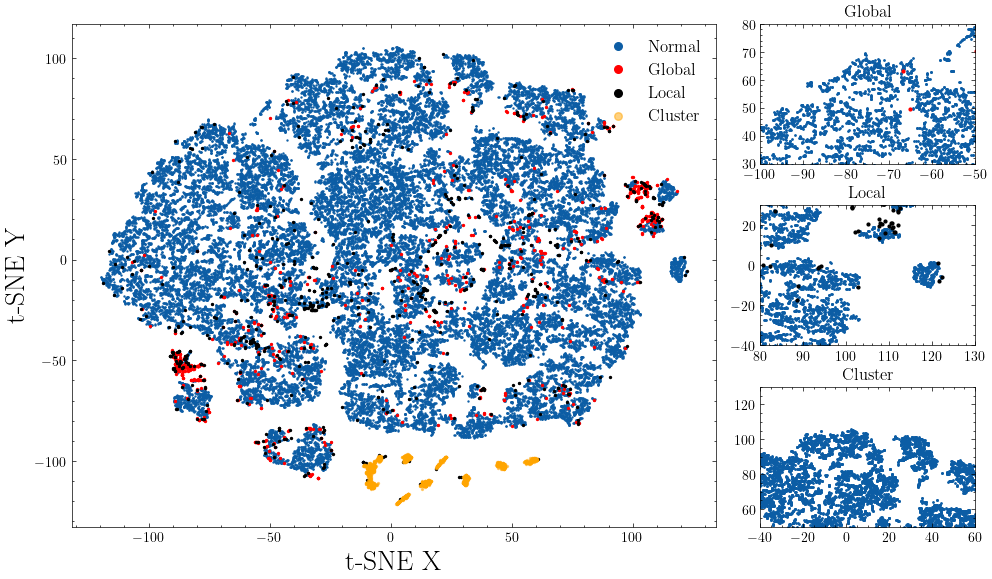

In [4]:
fig = plt.figure(figsize=(10, 6))

# Create a grid for the main plot and the panel
main_grid = fig.add_gridspec(1, 2, width_ratios=[3, 1])

# Main plot
main_plot = fig.add_subplot(main_grid[0, 0])

main_plot.scatter(
    output[output["label"] == 0]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=.5,
    marker="o",
    label="Normal"
)
main_plot.scatter(
    output[output["label"] == 1]["tsne_x"],
    output[output["label"] == 1]["tsne_y"],
    s=2,
    marker="o",
    c="r",
    label="Global"
)
main_plot.scatter(
    output[output["label"] == 2]["tsne_x"],
    output[output["label"] == 2]["tsne_y"],
    s=2,
    marker="o",
    c="black",
    label="Local"
)
main_plot.scatter(
    output[output["label"] == 3]["tsne_x"],
    output[output["label"] == 3]["tsne_y"],
    s=2,
    marker="o",
    c="orange",
    alpha=.5,
    label="Cluster"
)

main_plot.set_xlabel("t-SNE X", fontsize=20)
main_plot.set_ylabel("t-SNE Y", fontsize=20)

# Panel with subplots
panel_grid = main_grid[0, 1].subgridspec(3, 1, hspace=0.3)

# Create three smaller subplots in the panel
#for i in range(3):
ax = fig.add_subplot(panel_grid[0, 0])
ax.scatter(
    output[(output["label"] == 0)]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=1,
    marker="o",
)
ax.scatter(
    output[(output["label"] == 1)]["tsne_x"],
    output[output["label"] == 1]["tsne_y"],
    s=4,
    marker="o",
    c="r"
)


ax.set_xlim(-100,-50)
ax.set_ylim(30,80)
ax.set_title(f"Global")

ax = fig.add_subplot(panel_grid[1, 0])

ax.scatter(
    output[(output["label"] == 0)]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=1,
    marker="o",
)
ax.scatter(
    output[(output["label"] == 2)]["tsne_x"],
    output[output["label"] == 2]["tsne_y"],
    s=4,
    marker="o",
    c="black"
)
ax.set_xlim(80,130)
ax.set_ylim(-40,30)
ax.set_title(f"Local")

ax = fig.add_subplot(panel_grid[2, 0])
ax.scatter(
    output[(output["label"] == 0)]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=1,
    marker="o",
)
ax.scatter(
    output[(output["label"] == 3)]["tsne_x"],
    output[output["label"] == 3]["tsne_y"],
    s=4,
    marker="o",
    c="orange",
)
ax.set_ylim(50, 130)
ax.set_xlim(-40,60)
ax.set_title(f"Cluster")

# Adjust layout
plt.tight_layout()
legend = main_plot.legend(loc="upper right", fontsize=12, scatterpoints=1)
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
legend.legendHandles[3]._sizes = [30]

#plt.savefig("anom_types.png", dpi=500)
# Show the plot
plt.show()

In [5]:
global_df = output[~((output["label"] == 1) & (output["score"] >= 0)) & ((output["label"] == 1) | (output["label"] == 0))]
contamination_global = len(global_df[global_df["label"] == 1])/len(global_df)
global_df = global_df.to_numpy()

In [6]:
cluster_df = output[~((output["label"] == 3) & (output["score"] >= 0)) & ((output["label"] == 3) | (output["label"] == 0))]
contamination_cluster = len(cluster_df[cluster_df["label"] == 3])/len(cluster_df)
cluster_df = cluster_df.to_numpy()

In [7]:
local_df = output[(output["label"] == 0) | (output["label"] == 2)].to_numpy()
contamination_local = len(output[output["label"] == 2])/len(local_df)

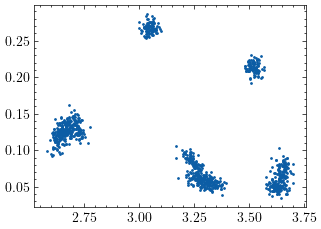

In [8]:
plt.scatter(
    output[output["label"] == 3].to_numpy()[:, 2], output[output["label"] == 3].to_numpy()[:, 3], s=1
)

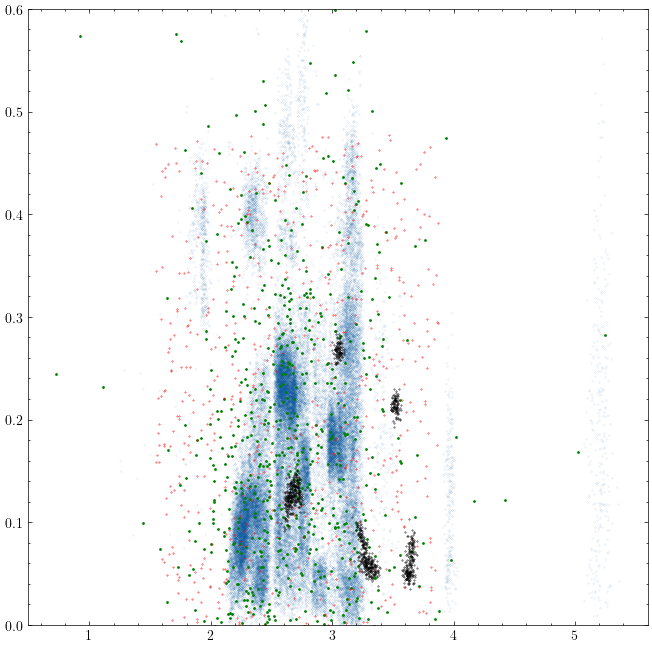

In [9]:
plt.subplots(figsize=(8,8))
plt.ylim(0, .6)
plt.scatter(
    output[output["label"] == 0].to_numpy()[:, 2], output[output["label"] == 0].to_numpy()[:, 3], s=.01, alpha=.5
)
plt.scatter(
    output[output["label"] == 2].to_numpy()[:, 2], output[output["label"] == 2].to_numpy()[:, 3], s=1, c="green"
)
plt.scatter(
    output[output["label"] == 1].to_numpy()[:, 2], output[output["label"] == 1].to_numpy()[:, 3], s=.1, c="red"
)

plt.scatter(
    output[output["label"] == 3].to_numpy()[:, 2], output[output["label"] == 3].to_numpy()[:, 3], s=.1, c="black"
)

## Local anomalies

In [29]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    local_scores_with_noise = algo_results(
        data = local_df,
        models = init_algos(
            contamination = contamination_local
        ),
        label = 2,
        noise_level = .25,
        with_noise = True
    )

In [24]:
local_results = result_df(
    local_scores_with_noise, anom_type = "local"
).drop(columns=["type"]).groupby(by=["Algorithm", "metric"])#.mean()

In [26]:
local_results.describe()

score                                          \
                        count      mean       std       min       25%   
Algorithm       metric                                                  
ABOD            BAL_ACC  10.0  0.579398  0.015696  0.549856  0.569812   
                F1       10.0  0.169405  0.029161  0.118765  0.152815   
CBLOF           BAL_ACC  10.0  0.509317  0.003869  0.503145  0.506648   
                F1       10.0  0.033196  0.007628  0.021322  0.027850   
CD              BAL_ACC  10.0  0.638718  0.044823  0.578222  0.598408   
                F1       10.0  0.102373  0.076398  0.040030  0.047175   
COPOD           BAL_ACC  10.0  0.597543  0.008354  0.583189  0.593850   
                F1       10.0  0.206142  0.014829  0.183486  0.195313   
Feature Bagging BAL_ACC  10.0  0.668134  0.018149  0.639278  0.654178   
                F1       10.0  0.339679  0.032496  0.292135  0.315544   
HBOS            BAL_ACC  10.0  0.614187  0.013071  0.591778  0.605536   
                F1       10.0  0.238107  0.023724  0.195991  0.226118   
IForest         BAL_ACC  10.0  0.579824  0.012013  0.558545  0.576578   
                F1       10.0  0.172354  0.023102  0.129590  0.166295   
KNN             BAL_ACC  10.0  0.609679  0.012387  0.583389  0.605534   
                F1       10.0  0.229225  0.020550  0.186047  0.218831   
LOF             BAL_ACC  10.0  0.615006  0.015457  0.591645  0.608875   
                F1       10.0  0.238354  0.027004  0.194260  0.224767   

                                                       
                              50%       75%       max  
Algorithm       metric                                 
ABOD            BAL_ACC  0.581278  0.593484  0.597056  
                F1       0.172336  0.187690  0.215962  
CBLOF           BAL_ACC  0.509034  0.511070  0.515223  
                F1       0.032472  0.036916  0.044944  
CD              BAL_ACC  0.653911  0.660023  0.717871  
                F1       0.052654  0.173730  0.224543  
COPOD           BAL_ACC  0.594928  0.604973  0.608789  
                F1       0.203624  0.216777  0.227790  
Feature Bagging BAL_ACC  0.671250  0.679006  0.693045  
                F1       0.340456  0.364334  0.390351  
HBOS            BAL_ACC  0.611795  0.623839  0.633934  
                F1       0.231701  0.256446  0.270396  
IForest         BAL_ACC  0.584017  0.587267  0.593434  
                F1       0.180046  0.188189  0.194570  
KNN             BAL_ACC  0.610817  0.617467  0.628456  
                F1       0.231852  0.243196  0.255924  
LOF             BAL_ACC  0.614367  0.620278  0.647367  
                F1       0.241101  0.248758  0.291755

## Global anomalies

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    global_scores_with_noise = algo_results(
        data = global_df,
        models = init_algos(
            contamination = contamination_global
        ),
        label = 1
    )

In [44]:
global_results = result_df(
    global_scores_with_noise, anom_type = "global"
).groupby(by=["Algorithm", "metric"])

In [45]:
global_results.describe()

score                                          \
                        count      mean       std       min       25%   
Algorithm       metric                                                  
ABOD            BAL_ACC  10.0  0.532039  0.013743  0.505576  0.523385   
                F1       10.0  0.069199  0.024576  0.018519  0.053048   
CBLOF           BAL_ACC  10.0  0.516710  0.007334  0.505776  0.511365   
                F1       10.0  0.040280  0.014359  0.019048  0.030462   
CD              BAL_ACC  10.0  0.507872  0.004614  0.500905  0.505451   
                F1       10.0  0.022488  0.008365  0.009091  0.018203   
COPOD           BAL_ACC  10.0  0.624367  0.019142  0.596099  0.611297   
                F1       10.0  0.257166  0.032863  0.197309  0.233841   
Feature Bagging BAL_ACC  10.0  0.646339  0.047604  0.578248  0.602013   
                F1       10.0  0.290557  0.086121  0.168224  0.204316   
HBOS            BAL_ACC  10.0  0.656926  0.026727  0.606008  0.638566   
                F1       10.0  0.317125  0.040386  0.242424  0.297700   
IForest         BAL_ACC  10.0  0.599793  0.049616  0.532903  0.563375   
                F1       10.0  0.205557  0.099262  0.075117  0.135633   
KNN             BAL_ACC  10.0  0.574574  0.017261  0.547216  0.563633   
                F1       10.0  0.159427  0.033801  0.114583  0.140114   
LOF             BAL_ACC  10.0  0.579726  0.027677  0.551154  0.562257   
                F1       10.0  0.163148  0.048055  0.113043  0.133239   

                                                       
                              50%       75%       max  
Algorithm       metric                                 
ABOD            BAL_ACC  0.534838  0.541520  0.550021  
                F1       0.076170  0.088241  0.098361  
CBLOF           BAL_ACC  0.516454  0.518981  0.528332  
                F1       0.039096  0.044995  0.065421  
CD              BAL_ACC  0.507461  0.509505  0.518089  
                F1       0.021812  0.025614  0.040161  
COPOD           BAL_ACC  0.628131  0.635855  0.658962  
                F1       0.266810  0.282751  0.296296  
Feature Bagging BAL_ACC  0.650903  0.690894  0.704907  
                F1       0.319777  0.358384  0.407080  
HBOS            BAL_ACC  0.659462  0.672901  0.691594  
                F1       0.321272  0.334434  0.396313  
IForest         BAL_ACC  0.589009  0.629916  0.678047  
                F1       0.176803  0.257366  0.372093  
KNN             BAL_ACC  0.575745  0.585747  0.596832  
                F1       0.158395  0.173814  0.218905  
LOF             BAL_ACC  0.573127  0.588441  0.645282  
                F1       0.147321  0.188690  0.269388

## Cluster anomalies

In [46]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    cluster_scores_with_noise = algo_results(
        data = cluster_df,
        models = init_algos(
            contamination_cluster
        ),
        label = 3.,
        noise_level=.25
    )

/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: Fut

In [52]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    cluster_results = result_df(
        cluster_scores_with_noise, anom_type = "cluster"
    ).groupby(by=["Algorithm", "metric"]).describe()
    cluster_results

## Global ranking

In [53]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    global_rank_scores_with_noise = algo_rank_results(
        data = global_df,
        models = init_algos(
            contamination = contamination_global
        ),
        label = 1,
        #with_noise = False,
        noise_level=.25
    )

In [56]:
pd.DataFrame(global_rank_scores_with_noise).describe()

,KNN,IForest,LOF,ABOD,CBLOF,CD,COPOD,Feature Bagging,HBOS
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.189600,0.418200,0.183000,0.226200,0.062000,0.454200,0.354800,0.334000,0.420200
std,0.014167,0.033366,0.015033,0.019078,0.010066,0.016904,0.013669,0.041236,0.020687
min,0.162000,0.358000,0.164000,0.188000,0.042000,0.432000,0.334000,0.272000,0.396000
25%,0.184000,0.407000,0.171000,0.217500,0.059000,0.440000,0.344500,0.315500,0.400500
50%,0.191000,0.423000,0.182000,0.230000,0.063000,0.455000,0.354000,0.335000,0.424000
75%,0.195500,0.439500,0.189000,0.237000,0.066000,0.468000,0.365000,0.354000,0.432500
max,0.208000,0.458000,0.214000,0.252000,0.080000,0.480000,0.376000,0.398000,0.458000


## Cluster ranking evaluation

In [57]:

cluster_rank_scores_with_noise = algo_rank_results(
    data = cluster_df,
    models = init_algos(
        contamination = contamination_global
    ),
    label = 3,
    #with_noise = False,
    noise_level= .25
)

/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: Fut

In [58]:
pd.DataFrame(cluster_rank_scores_with_noise).describe()

,KNN,IForest,LOF,ABOD,CBLOF,CD,COPOD,Feature Bagging,HBOS
count,10.000000,10.000000,10.000000,10.00000,10.000000,10.0000,10.000000,10.00000,10.0000
mean,0.064600,0.639000,0.091400,0.09400,0.042800,0.6842,0.630400,0.18260,0.6370
std,0.009383,0.013038,0.014269,0.00718,0.010922,0.0078,0.010617,0.02491,0.0162
min,0.050000,0.622000,0.074000,0.08400,0.026000,0.6720,0.616000,0.12000,0.6060
25%,0.062000,0.626500,0.080500,0.08850,0.037000,0.6805,0.622000,0.18100,0.6290
50%,0.063000,0.641000,0.091000,0.09200,0.044000,0.6850,0.629000,0.18900,0.6370
75%,0.067500,0.651000,0.098500,0.09950,0.048000,0.6900,0.638500,0.19600,0.6485
max,0.082000,0.654000,0.122000,0.10600,0.062000,0.6940,0.646000,0.20600,0.6620


## Local ranking evaluation

In [59]:
import joblib 
from evaluation import algo_rank_local_results

anom_gen = joblib.load(open("../synthetic_anomalies/gmm/gmm.joblib", "rb"))
params = anom_gen._get_parameters()

In [60]:
arr = np.vectorize(lambda x: params[1][int(x)][0])(local_df[:, 7]).reshape(-1, 1)
for i in range(1, 5):
    arr = np.hstack((arr, np.vectorize(lambda x: params[1][int(x)][int(i)])(local_df[:, 7]).reshape(-1, 1)))

centroid_dist = np.linalg.norm(scaler.inverse_transform(arr) - local_df[:, 0:5], axis=1)

scaled_centroid_dist = (centroid_dist - centroid_dist.min())
scaled_centroid_dist /= scaled_centroid_dist.max()

In [64]:
from sklearn.model_selection import train_test_split

def algo_rank_local_results(data, label, iterations = 10, with_noise=True, noise_level = 0, silent = False):
    rank_scores = {key : [] for key in models}
    '''if anom_type == "local":
        idx = -1
    else:'''
    idx = -1

    for i in range(iterations):
        if with_noise:
            duplicate_idx = np.random.choice(500, size=100, replace=False)

            noisy_features = data[:, :5] + noise_level*data[:, -6:-1]
            noisy_features =  np.concatenate([noisy_features, noisy_features[duplicate_idx, 0:5]]) # Add duplicates

            noisy_scores = np.concatenate([data[:, idx], data[duplicate_idx, idx]])
            noisy_labels = np.concatenate([data[:, 5], data[duplicate_idx, 5]])

            # Should I make use of training score?
            X_train, X_test, y_train, y_test = train_test_split(
                noisy_features, 
                noisy_scores, 
                test_size=.3,
                #random_state=42,
                stratify=noisy_labels,
                shuffle=True
            )
                    
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                data[:, 0:5], 
                data[:, idx], # score column of dataset
                test_size=.3,
                #random_state=42,
                stratify=data[:, 5],
                shuffle=True
            )

        rn_model_idx = np.argsort(y_test)[-500::]

        for name, clf in zip(models.keys(), models.values()):
            
            clf.fit(X_train)
            # get the prediction labels and outlier scores of the training data
            #y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
            #y_train_scores = clf.decision_scores_  # raw outlier scores
            

            # get the prediction on the test data
            #y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
            y_test_scores = clf.decision_function(X_test)  # outlier scoress
            
            '''rn_algo_scores = y_test_scores - y_test_scores.min()
            rn_algo_scores /= rn_algo_scores.max()
            
            rn_model_scores = abs(y_test - y_test.max())
            rn_model_scores /= rn_model_scores.max()
            '''
            #acc = balanced_accuracy_score(y_test, label*y_test_pred)
            #model_scores = anom_gen.gmm.score_samples(X_test)
            ''' print(np.argsort(y_test_scores)[::-1])
                print(np.argsort(y_test))'''
            #print(y_test_scores, model_scores.min())


            err_score = len(np.intersect1d(rn_model_idx, np.argsort(y_test_scores)[-500::])) / 500 # Overlap of the top 100 outliers.
            rank_scores[name].append(err_score)
            
            #rank_scores[name].append(kendalltau(rn_model_scores, rn_algo_scores).correlation)
            #print(f"Name: {name}, spearman: {spearmanr(rn_model_scores, rn_algo_scores)}")
            '''if not silent:
                print(name)
                print(f"Accuracy metric: {rank_scores[name]})")
                print(("------"))'''

    return rank_scores

In [66]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    local_rank_scores_with_noise = algo_rank_local_results(
        data = np.hstack((local_df, scaled_centroid_dist.reshape(-1,1))),
        label = 2,
        #with_noise = False,
        noise_level=.25
    )

In [67]:
pd.DataFrame(local_rank_scores_with_noise).describe()

,KNN,IForest,LOF,ABOD,CBLOF,CD,COPOD,Feature Bagging,HBOS
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.087800,0.606600,0.096000,0.118000,0.143600,0.534000,0.526400,0.163600,0.446200
std,0.014921,0.033929,0.012074,0.013952,0.014901,0.057069,0.016621,0.030938,0.113178
min,0.054000,0.562000,0.074000,0.098000,0.126000,0.378000,0.492000,0.106000,0.252000
25%,0.084000,0.594000,0.089500,0.110500,0.130000,0.542000,0.517500,0.146500,0.360500
50%,0.087000,0.604000,0.096000,0.115000,0.142000,0.549000,0.531000,0.162000,0.495000
75%,0.093500,0.617000,0.100000,0.122500,0.155500,0.560000,0.533500,0.188000,0.501500
max,0.108000,0.686000,0.118000,0.148000,0.170000,0.580000,0.556000,0.204000,0.566000
